In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [2]:
#Training parameters
data_augmentation = True
num_classes = 10

In [3]:
#Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [4]:
#How many layers? Depends on the model version
def model_depth(version,n=3):
    """
    Computes depth from supplied model parameter n
    """
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2
    return depth

In [5]:
def model_type(version,n):
    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (model_depth(version,n), version)
    return model_type

In [6]:
model_t = model_type(2,3)
print(model_t)

ResNet29v2


In [7]:
#Function to show any data
def show_data(sample):
    """
    Shows the given sample data as an image
    """
    import matplotlib.pyplot as plt
    plt.imshow(sample)
    plt.show()

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

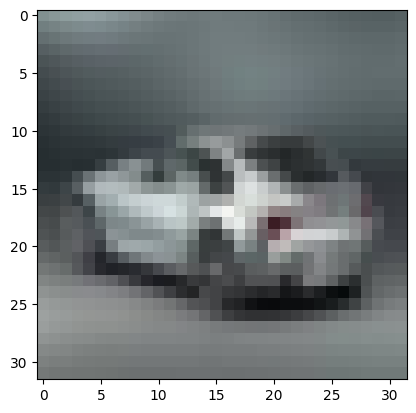

In [9]:
show_data(x_train[250])

In [10]:
# Input image dimensions.
input_shape = x_train.shape[1:]

In [11]:
#normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [12]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean
    
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [13]:
#Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [14]:
#Function for auto-scaling learning based on epochs
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [15]:
#Function of a single ResNet layer
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [16]:
#ResNet Version 1 model builder
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
     # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
#ResNet Version 2 model builder
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
         for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            num_filters_in = num_filters_out
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
def choose_model(version=1):
    """
    Chooses the model based on version
    
    # Argument:
        An (int) version number (1 or 2)
    # Returns:
        keras model
    """
    if version == 2:
        model = resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = resnet_v1(input_shape=input_shape, depth=depth)
    return model

In [19]:
version = 1
n = 3

In [20]:
depth = model_depth(version=version,n=n)
model = choose_model(version)

In [21]:
print(model_type(version,n))

ResNet20v1


In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch

C:\Users\parjita\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 activation_7 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 32)   9248        ['activation_7[0][0]']           
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 32)   544         ['activation_6[0][0]']           
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 16, 16, 32)  128         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 add_3 (Add)                    (None, 16, 16, 32)   0           ['conv2d_9[0][0]',               
          

In [23]:

#Prepare model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [24]:
#Prepare callbacks for model saving and for learning rate adjustment
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             period=3
                            )

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [25]:
# For now, we will not save the models, so won't include the `checkpoint` in the `callbacks`
callbacks = [lr_reducer, lr_scheduler]

In [26]:
#training
from time import time
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 3
t1 = time()
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
t2 = time()

Learning rate:  0.001
Epoch 1/3
1563/1563 [==============================] - 696s 440ms/step - loss: 1.4858 - accuracy: 0.5226 - val_loss: 1.4802 - val_accuracy: 0.5274 - lr: 0.0010
Learning rate:  0.001
Epoch 2/3
1563/1563 [==============================] - 513s 328ms/step - loss: 1.0763 - accuracy: 0.6704 - val_loss: 1.0867 - val_accuracy: 0.6754 - lr: 0.0010
Learning rate:  0.001
Epoch 3/3
1563/1563 [==============================] - 485s 310ms/step - loss: 0.9176 - accuracy: 0.7334 - val_loss: 1.0808 - val_accuracy: 0.6906 - lr: 0.0010


In [27]:
time_delta=round((t2-t1)/60,2)

print ("Training of {} epochs took {} minutes total.".format(epochs, time_delta))

Training of 3 epochs took 28.27 minutes total.


In [28]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 29s 92ms/step - loss: 1.0808 - accuracy: 0.6906
Test loss: 1.0807651281356812
Test accuracy: 0.6905999779701233


In [29]:
#A smaller learning rate and larger batch size
version = 1
n = 3

depth = model_depth(version=version,n=n)
model = choose_model(version)
# Hard coding the learning rate = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 3
# Note, we turn off the callbacks as we want to use the new learning rate
t1 = time()
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              shuffle=True)
t2 = time()

Epoch 1/3
391/391 [==============================] - 401s 1s/step - loss: 2.0886 - accuracy: 0.3372 - val_loss: 1.9056 - val_accuracy: 0.3750
Epoch 2/3
391/391 [==============================] - 486s 1s/step - loss: 1.6123 - accuracy: 0.4713 - val_loss: 1.5440 - val_accuracy: 0.4943
Epoch 3/3
391/391 [==============================] - 449s 1s/step - loss: 1.4729 - accuracy: 0.5239 - val_loss: 1.4573 - val_accuracy: 0.5292


In [30]:
time_delta=round((t2-t1)/60,2)

print ("Training of {} epochs took {} minutes total.".format(epochs, time_delta))

Training of 3 epochs took 22.29 minutes total.


In [33]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 26s 84ms/step - loss: 1.4573 - accuracy: 0.5292
Test loss: 1.4573472738265991
Test accuracy: 0.52920001745224


In [35]:
#More variation and longer training...
version = 1
n = 4

depth = model_depth(version=version,n=n)
model = choose_model(version)

print("Model type:",model_type(version,n))
print("There are, in total, {} parameters in this model!".format(model.count_params()))



Model type: ResNet26v1
There are, in total, 372330 parameters in this model!


In [36]:
# Hard coding the learning rate = 1e-3
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3),
              metrics=['accuracy'])
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 3
callbacks = [lr_reducer]

C:\Users\parjita\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [38]:
# Note, we turn off the callbacks as we want to use the new learning rate
t1 = time()
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
t2 = time()

Epoch 1/3
391/391 [==============================] - 629s 2s/step - loss: 1.6577 - accuracy: 0.4706 - val_loss: 1.8276 - val_accuracy: 0.4546 - lr: 0.0010
Epoch 2/3
391/391 [==============================] - 534s 1s/step - loss: 1.1939 - accuracy: 0.6406 - val_loss: 1.3943 - val_accuracy: 0.5742 - lr: 0.0010
Epoch 3/3
391/391 [==============================] - 526s 1s/step - loss: 0.9815 - accuracy: 0.7179 - val_loss: 1.7796 - val_accuracy: 0.5082 - lr: 0.0010


In [39]:
time_delta=round((t2-t1)/60,2)

print ("Training of {} epochs took {} minutes total.".format(epochs, time_delta))

Training of 3 epochs took 28.2 minutes total.


In [40]:

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 32s 101ms/step - loss: 1.7796 - accuracy: 0.5082
Test loss: 1.779614806175232
Test accuracy: 0.5081999897956848
